# Carvana Image Segmentation   

## Overview

1. Import Libraries
2. Image Processing (Resizing if required)
3. Run Length Encoding 
3. Loss Lunction (Dice Coefficient)
4. Build U-net Model/ ResNet Model -> Evaluation
5. Conclusion

### Import Libraries

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math
%matplotlib inline
from scipy import ndimage
import random
import os
from os import listdir
from os.path import isfile, join
import imageio

from sklearn.model_selection import train_test_split
from skimage import color
from skimage import io
from skimage import img_as_ubyte

import keras.backend as K
from keras.losses import binary_crossentropy
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras.optimizers import RMSprop, Adam
from keras.models import Model

In [59]:
# Read train_mask csv
train_mask = pd.read_csv('train_masks.csv')
train_mask.head()

,img,rle_mask
0,00087a6bd4dc_01.jpg,879386 40 881253 141 883140 205 885009 17 8850...
1,00087a6bd4dc_02.jpg,873779 4 875695 7 877612 9 879528 12 881267 15...
2,00087a6bd4dc_03.jpg,864300 9 866217 13 868134 15 870051 16 871969 ...
3,00087a6bd4dc_04.jpg,879735 20 881650 26 883315 92 883564 30 885208...
4,00087a6bd4dc_05.jpg,883365 74 883638 28 885262 119 885550 34 88716...


In [62]:
train_img_id = list(train_mask['img'])
train_img_id

['00087a6bd4dc_01.jpg',
 '00087a6bd4dc_02.jpg',
 '00087a6bd4dc_03.jpg',
 '00087a6bd4dc_04.jpg',
 '00087a6bd4dc_05.jpg',
 '00087a6bd4dc_06.jpg',
 '00087a6bd4dc_07.jpg',
 '00087a6bd4dc_08.jpg',
 '00087a6bd4dc_09.jpg',
 '00087a6bd4dc_10.jpg',
 '00087a6bd4dc_11.jpg',
 '00087a6bd4dc_12.jpg',
 '00087a6bd4dc_13.jpg',
 '00087a6bd4dc_14.jpg',
 '00087a6bd4dc_15.jpg',
 '00087a6bd4dc_16.jpg',
 '02159e548029_01.jpg',
 '02159e548029_02.jpg',
 '02159e548029_03.jpg',
 '02159e548029_04.jpg',
 '02159e548029_05.jpg',
 '02159e548029_06.jpg',
 '02159e548029_07.jpg',
 '02159e548029_08.jpg',
 '02159e548029_09.jpg',
 '02159e548029_10.jpg',
 '02159e548029_11.jpg',
 '02159e548029_12.jpg',
 '02159e548029_13.jpg',
 '02159e548029_14.jpg',
 '02159e548029_15.jpg',
 '02159e548029_16.jpg',
 '03a857ce842d_01.jpg',
 '03a857ce842d_02.jpg',
 '03a857ce842d_03.jpg',
 '03a857ce842d_04.jpg',
 '03a857ce842d_05.jpg',
 '03a857ce842d_06.jpg',
 '03a857ce842d_07.jpg',
 '03a857ce842d_08.jpg',
 '03a857ce842d_09.jpg',
 '03a857ce842d_1

## Read single image

/Users/YLChua/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  """Entry point for launching an IPython kernel.


(1280, 1918, 3)


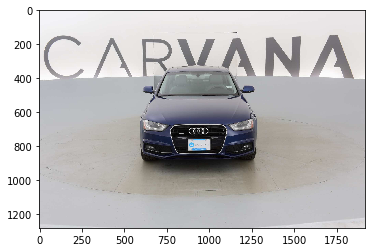

In [5]:
test_img = ndimage.imread('train/0cdf5b5d0ce1_01.jpg')
print(test_img.shape)
plt.imshow(test_img)
plt.show()

/Users/YLChua/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  


(1280, 1918)


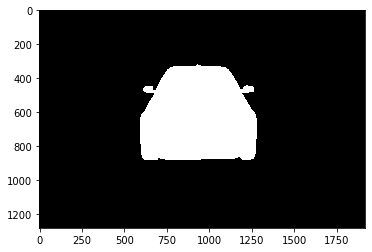

In [63]:
path ='train_masks/'
ext = '_mask.gif'

def show_mask_image(car_code, angle_code):
    mask_img_path = path  + car_code + '_' + angle_code + ext
    mask_img = ndimage.imread(mask_img_path, mode = 'L')
    print(mask_img.shape)
    plt.imshow(mask_img, cmap = 'Greys_r')
    plt.show()

show_mask_image('0cdf5b5d0ce1', '01')    

## Plot a few image and analysis 

In [55]:
def plot_images(img_id):
    orig_img = cv2.imread('train/' + img_id + '.jpg')
    mask     = ndimage.imread('train_masks/' + img_id + '_mask.gif', mode = 'L')
    merge    = cv2.bitwise_and(orig_img,orig_img, mask = mask)
    
    plt.figure(figsize=(20,20))
    plt.subplot(1,3,1)
    plt.imshow(orig_img)
    plt.subplot(1,3,2)
    plt.imshow(mask)
    plt.subplot(1,3,3)
    plt.imshow(merge)
    plt.show()
    

/Users/YLChua/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


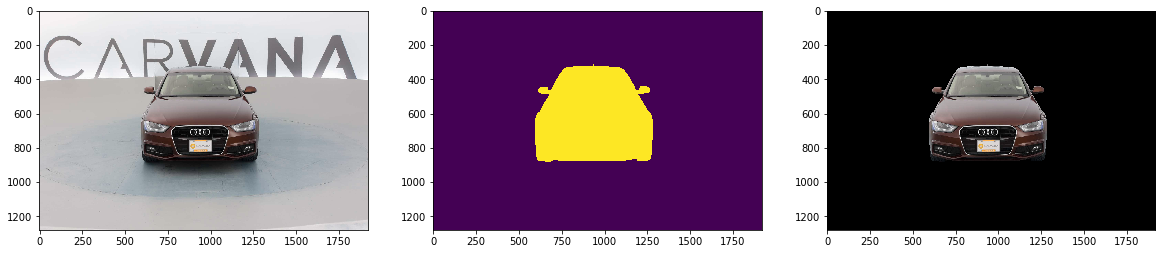

In [56]:
plot_images('0cdf5b5d0ce1_01')

/Users/YLChua/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


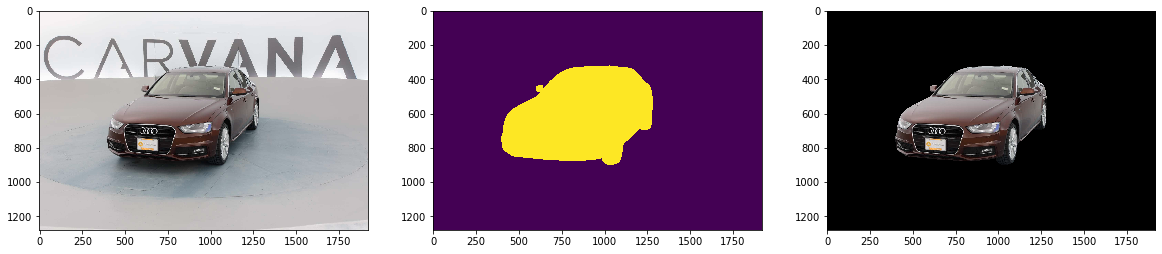

In [69]:
plot_images('0cdf5b5d0ce1_02')

/Users/YLChua/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


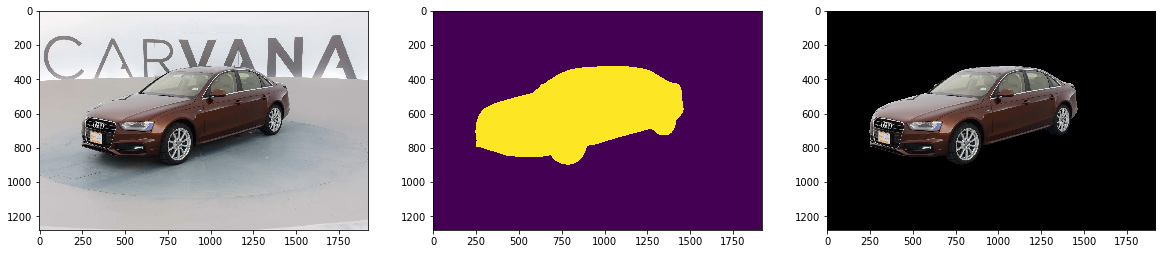

In [70]:
plot_images('0cdf5b5d0ce1_03')

## import in matadata csv

In [66]:
metadata = pd.read_csv('metadata.csv')
print( metadata.shape)
metadata.head()

(6572, 6)


,id,year,make,model,trim1,trim2
0,0004d4463b50,2014.0,Acura,TL,TL,w/SE
1,00087a6bd4dc,2014.0,Acura,RLX,RLX,w/Tech
2,000aa097d423,2012.0,Mazda,MAZDA6,MAZDA6,i Sport
3,000f19f6e7d4,2016.0,Chevrolet,Camaro,Camaro,SS
4,00144e887ae9,2015.0,Acura,TLX,TLX,SH-AWD V6 w/Advance Pkg


In [68]:
metadata.isnull().sum()

id        0
year     11
make     11
model    11
trim1    62
trim2    77
dtype: int64

## define loss function according to Dice loss function stated in kaggle

In [18]:

def dice_loss(y_true,y_pred):
    smooth = 1.0
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)
    intersection = K.sum(y_true_flatten * y_pred_flatten)
    return (2 * intersection + smooth) /(K.sum(y_true_flatten)+ K.sum(y_pred_flatten) + smooth)

def bce_dice_loss(y_true,y_pred):
    bce = binary_crossentropy(y_true,y_pred) + (1 - dice_loss(y_true,y_pred))
    return bce
    

## UNet 256 x 256 input model

### Define Each block separately and then form Unet architecture
1. Input is set to 256x256 (square)
2. output will be in the same format
3. smallest output shape will be 8x8 
4. [256 - 128 - 64 - 32 - 16 - 8 - 16 - 32 - 64 - 128 - 256]


In [19]:
# one down size block consist of 2 sets of conv + batchNorm + activation --> followed by max pooling2D
def downsampling_one_block(down_inputs,filters):
    x = Conv2D(filters,(3,3), padding ='same')(down_inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
#     Repeat 
    x = Conv2D(filters,(3,3), padding ='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def upsampling_one_block(up_inputs, down_input,filters):
    #taking in input from downsampling and upsampling and combining together
    x = UpSampling2D((2,2))(up_inputs)
    x = concatenate([down_input,x], axis=3)
    
    #3 sets of layers of conv + batchNorm + activation --> followed by max pooling2D
    x = Conv2D(filters,(3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters,(3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters,(3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x
    
def max_pooling(inputs):
    x = MaxPooling2D((2,2), strides=(2,2))(inputs)
    return x

In [77]:
def unet_256(input_shape =(256,256,3),
             classes = 1,              # Reduce dimensions to 1 for mask tensor output
             initial_filter = 8,
             central_filter = 256):
    
    num_filters = initial_filter
    out_list = [Input(shape=input_shape)]
    down_interim_list = []
    
    while num_filters <= central_filter/2 :
        print('')
        print('A. num_filters, central_filter, out_list, down_interim_list',num_filters, central_filter, out_list, down_interim_list)
        print('')
        
        x = downsampling_one_block(out_list[-1],num_filters)
        down_interim_list.append(x)
        num_filters = num_filters *2
        y = max_pooling(x)
        out_list.append(y)
        
        print('B. num_filters, central_filter, out_list, down_interim_list',num_filters, central_filter, out_list, down_interim_list)
        
    x = downsampling_one_block(out_list[-1], num_filters)
    out_list.append(x)
    num_filters = int(num_filters/2)
    print('')
    print('1.' ,num_filters)
    
    while num_filters >= initial_filter:
        print('')
        print('C. num_filters, central_filter, out_list, down_interim_list',num_filters, central_filter, out_list, down_interim_list)
        print('')
        x = upsampling_one_block(out_list[-1], down_interim_list.pop(),num_filters)
        out_list.append(x)
        num_filters = int(num_filters/2)
        print('D. num_filters, central_filter, out_list, down_interim_list',num_filters, central_filter, out_list, down_interim_list)
        
    classify = Conv2D(classes, (1,1), activation='sigmoid')(out_list[-1])
    print('   ',out_list)
    model = Model(inputs = out_list[0], outputs = classify)
    
    model.compile(optimizer=RMSprop(lr = 0.0001),
                 loss = bce_dice_loss,
                 metrics =[dice_loss])
    return model

In [78]:
model = unet_256()
model.summary()


A. num_filters, central_filter, out_list, down_interim_list 8 256 [<tf.Tensor 'input_3:0' shape=(None, 256, 256, 3) dtype=float32>] []

B. num_filters, central_filter, out_list, down_interim_list 16 256 [<tf.Tensor 'input_3:0' shape=(None, 256, 256, 3) dtype=float32>, <tf.Tensor 'max_pooling2d_11/MaxPool:0' shape=(None, 128, 128, 8) dtype=float32>] [<tf.Tensor 'activation_56/Relu:0' shape=(None, 256, 256, 8) dtype=float32>]

A. num_filters, central_filter, out_list, down_interim_list 16 256 [<tf.Tensor 'input_3:0' shape=(None, 256, 256, 3) dtype=float32>, <tf.Tensor 'max_pooling2d_11/MaxPool:0' shape=(None, 128, 128, 8) dtype=float32>] [<tf.Tensor 'activation_56/Relu:0' shape=(None, 256, 256, 8) dtype=float32>]

B. num_filters, central_filter, out_list, down_interim_list 32 256 [<tf.Tensor 'input_3:0' shape=(None, 256, 256, 3) dtype=float32>, <tf.Tensor 'max_pooling2d_11/MaxPool:0' shape=(None, 128, 128, 8) dtype=float32>, <tf.Tensor 'max_pooling2d_12/MaxPool:0' shape=(None, 64, 64, 1

D. num_filters, central_filter, out_list, down_interim_list 32 256 [<tf.Tensor 'input_3:0' shape=(None, 256, 256, 3) dtype=float32>, <tf.Tensor 'max_pooling2d_11/MaxPool:0' shape=(None, 128, 128, 8) dtype=float32>, <tf.Tensor 'max_pooling2d_12/MaxPool:0' shape=(None, 64, 64, 16) dtype=float32>, <tf.Tensor 'max_pooling2d_13/MaxPool:0' shape=(None, 32, 32, 32) dtype=float32>, <tf.Tensor 'max_pooling2d_14/MaxPool:0' shape=(None, 16, 16, 64) dtype=float32>, <tf.Tensor 'max_pooling2d_15/MaxPool:0' shape=(None, 8, 8, 128) dtype=float32>, <tf.Tensor 'activation_66/Relu:0' shape=(None, 8, 8, 256) dtype=float32>, <tf.Tensor 'activation_69/Relu:0' shape=(None, 16, 16, 128) dtype=float32>, <tf.Tensor 'activation_72/Relu:0' shape=(None, 32, 32, 64) dtype=float32>] [<tf.Tensor 'activation_56/Relu:0' shape=(None, 256, 256, 8) dtype=float32>, <tf.Tensor 'activation_58/Relu:0' shape=(None, 128, 128, 16) dtype=float32>, <tf.Tensor 'activation_60/Relu:0' shape=(None, 64, 64, 32) dtype=float32>]

C. num_

In [21]:
# train_mask
img_id = train_mask['img'].map(lambda x: x.split('.')[0])
img_id

0       00087a6bd4dc_01
1       00087a6bd4dc_02
2       00087a6bd4dc_03
3       00087a6bd4dc_04
4       00087a6bd4dc_05
             ...       
5083    fff9b3a5373f_12
5084    fff9b3a5373f_13
5085    fff9b3a5373f_14
5086    fff9b3a5373f_15
5087    fff9b3a5373f_16
Name: img, Length: 5088, dtype: object

In [22]:
X_train_img_id , X_valid_img_id = train_test_split(img_id, test_size = 0.2, random_state =27)

In [34]:
np.random.uniform(0,0.5,1)

array([0.01980043])

### input randomness for hue saturaturation
image data generator

In [37]:
def randomHueSaturationValue(image, hue_shift_limit=(-180, 180),
                             sat_shift_limit=(-255, 255),
                             val_shift_limit=(-255, 255), u=0.5):
    if np.random.random() < u:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(image)
        hue_shift = np.random.uniform(hue_shift_limit[0], hue_shift_limit[1])
        h = cv2.add(h, hue_shift)
        sat_shift = np.random.uniform(sat_shift_limit[0], sat_shift_limit[1])
        s = cv2.add(s, sat_shift)
        val_shift = np.random.uniform(val_shift_limit[0], val_shift_limit[1])
        v = cv2.add(v, val_shift)
        image = cv2.merge((h, s, v))
        image = cv2.cvtColor(image, cv2.COLOR_HSV2BGR)

    return image

In [38]:
def randomShiftScaleRotate(image, mask,
                           shift_limit=(-0.0625, 0.0625),
                           scale_limit=(-0.1, 0.1),
                           rotate_limit=(-45, 45), aspect_limit=(0, 0),
                           borderMode=cv2.BORDER_CONSTANT, u=0.5):
    if np.random.random() < u:
        height, width, channel = image.shape

        angle = np.random.uniform(rotate_limit[0], rotate_limit[1])  # degree
        scale = np.random.uniform(1 + scale_limit[0], 1 + scale_limit[1])
        aspect = np.random.uniform(1 + aspect_limit[0], 1 + aspect_limit[1])
        sx = scale * aspect / (aspect ** 0.5)
        sy = scale / (aspect ** 0.5)
        dx = round(np.random.uniform(shift_limit[0], shift_limit[1]) * width)
        dy = round(np.random.uniform(shift_limit[0], shift_limit[1]) * height)

        cc = np.math.cos(angle / 180 * np.math.pi) * sx
        ss = np.math.sin(angle / 180 * np.math.pi) * sy
        rotate_matrix = np.array([[cc, -ss], [ss, cc]])

        box0 = np.array([[0, 0], [width, 0], [width, height], [0, height], ])
        box1 = box0 - np.array([width / 2, height / 2])
        box1 = np.dot(box1, rotate_matrix.T) + np.array([width / 2 + dx, height / 2 + dy])

        box0 = box0.astype(np.float32)
        box1 = box1.astype(np.float32)
        mat = cv2.getPerspectiveTransform(box0, box1)
        image = cv2.warpPerspective(image, mat, (width, height), flags=cv2.INTER_LINEAR, borderMode=borderMode,
                                    borderValue=(0, 0, 0,))
        mask = cv2.warpPerspective(mask, mat, (width, height), flags=cv2.INTER_LINEAR, borderMode=borderMode,
                                   borderValue=(0, 0, 0,))

    return image, mask


In [39]:
def randomHorizontalFlip(image, mask, u=0.5):
    if np.random.random() < u:
        image = cv2.flip(image, 1)
        mask = cv2.flip(mask, 1)

    return image, mask


## train data generator and validate data generator

In [98]:
def train_generator():
    
    while True:
        this_ids_train_split = random.sample(list(X_train_img_id), len(X_train_img_id))
        for start in range(0, len(X_train_img_id), batch_size):
            x_batch = []
            y_batch = []
            end = min(start + batch_size, len(X_train_img_id))
            ids_train_batch = this_ids_train_split[start:end]
            for id in ids_train_batch:
                img  = cv2.imread('train/{}.jpg'.format(id))
                img  = cv2.resize(img, (input_size, input_size))
                mask = imageio.imread('train_masks/{}_mask.gif'.format(id))
                mask = cv2.resize(mask, (input_size, input_size))
                img  = randomHueSaturationValue(img,
                                               hue_shift_limit=(-50, 50),
                                               sat_shift_limit=(-5, 5),
                                               val_shift_limit=(-15, 15))
                img, mask = randomShiftScaleRotate(img, mask,
                                                   shift_limit=(-0.0625, 0.0625),
                                                   scale_limit=(-0.1, 0.1),
                                                   rotate_limit=(-0, 0))
                img, mask = randomHorizontalFlip(img, mask)
                mask = np.expand_dims(mask, axis=2)
                x_batch.append(img)
                y_batch.append(mask)
            x_batch = np.array(x_batch, np.float32) / 255
            y_batch = np.array(y_batch, np.float32) / 255
            yield x_batch, y_batch


In [99]:
def valid_generator():
    while True:
        for start in range(0, len(X_valid_img_id), batch_size):
            x_batch = []
            y_batch = []
            end = min(start + batch_size, len(X_valid_img_id))
            ids_valid_batch = X_valid_img_id[start:end]
            for id in ids_valid_batch.values:
                img = cv2.imread('train/{}.jpg'.format(id))
                img = cv2.resize(img, (input_size, input_size))
#                 mask = cv2.imread('train_masks/{}_mask.gif'.format(id), cv2.IMREAD_GRAYSCALE)
                mask = imageio.imread('train_masks/{}_mask.gif'.format(id))
                mask = cv2.resize(mask, (input_size, input_size))
                mask = np.expand_dims(mask, axis=2)
                x_batch.append(img)
                y_batch.append(mask)
            x_batch = np.array(x_batch, np.float32) / 255
            y_batch = np.array(y_batch, np.float32) / 255
            yield x_batch, y_batch



## call backs for early stopping

In [100]:
callbacks = [EarlyStopping(monitor='val_dice_loss',
                           patience=8,
                           verbose=1,
                           min_delta=1e-4,
                           mode='max'),
             ReduceLROnPlateau(monitor='val_dice_loss',
                               factor=0.1,
                               patience=4,
                               verbose=1,
                               epsilon=1e-4,
                               mode='max'),
             ModelCheckpoint(monitor='val_dice_loss',
                             filepath='Unet_256_weights.hdf5',
                             save_best_only=True,
                             save_weights_only=True,
                             mode='max'),
             TensorBoard(log_dir='logs')]

In [27]:
input_size = 256
max_epochs = 50
batch_size = 16
orig_width = 1918
orig_height= 1280
threshold  = 0.5

In [102]:
history = model.fit_generator(generator=train_generator(),
                    steps_per_epoch=np.ceil(float(len(X_train_img_id)) / float(batch_size)),
                    epochs=max_epochs,
                    verbose=2,
                    callbacks=callbacks,
                    validation_data=valid_generator(),
                    validation_steps=np.ceil(float(len(X_valid_img_id)) / float(batch_size)))

Epoch 1/50


KeyboardInterrupt: 

# Predictions

In [3]:
from tqdm import tqdm

In [4]:
df_test = pd.read_csv('sample_submission.csv')
df_test.head()

,img,rle_mask
0,0004d4463b50_01.jpg,1 1
1,0004d4463b50_02.jpg,1 1
2,0004d4463b50_03.jpg,1 1
3,0004d4463b50_04.jpg,1 1
4,0004d4463b50_05.jpg,1 1


In [9]:
ids_test = list(df_test['img'].map(lambda s: s.split('.')[0] +'.jpg'))
ids_test

['0004d4463b50_01.jpg',
 '0004d4463b50_02.jpg',
 '0004d4463b50_03.jpg',
 '0004d4463b50_04.jpg',
 '0004d4463b50_05.jpg',
 '0004d4463b50_06.jpg',
 '0004d4463b50_07.jpg',
 '0004d4463b50_08.jpg',
 '0004d4463b50_09.jpg',
 '0004d4463b50_10.jpg',
 '0004d4463b50_11.jpg',
 '0004d4463b50_12.jpg',
 '0004d4463b50_13.jpg',
 '0004d4463b50_14.jpg',
 '0004d4463b50_15.jpg',
 '0004d4463b50_16.jpg',
 '000aa097d423_01.jpg',
 '000aa097d423_02.jpg',
 '000aa097d423_03.jpg',
 '000aa097d423_04.jpg',
 '000aa097d423_05.jpg',
 '000aa097d423_06.jpg',
 '000aa097d423_07.jpg',
 '000aa097d423_08.jpg',
 '000aa097d423_09.jpg',
 '000aa097d423_10.jpg',
 '000aa097d423_11.jpg',
 '000aa097d423_12.jpg',
 '000aa097d423_13.jpg',
 '000aa097d423_14.jpg',
 '000aa097d423_15.jpg',
 '000aa097d423_16.jpg',
 '000f19f6e7d4_01.jpg',
 '000f19f6e7d4_02.jpg',
 '000f19f6e7d4_03.jpg',
 '000f19f6e7d4_04.jpg',
 '000f19f6e7d4_05.jpg',
 '000f19f6e7d4_06.jpg',
 '000f19f6e7d4_07.jpg',
 '000f19f6e7d4_08.jpg',
 '000f19f6e7d4_09.jpg',
 '000f19f6e7d4_1

In [32]:
len(ids_test), batch_size, ids_test_batch

(100064,
 16,
 ['0004d4463b50_01.jpg',
  '0004d4463b50_02.jpg',
  '0004d4463b50_03.jpg',
  '0004d4463b50_04.jpg',
  '0004d4463b50_05.jpg',
  '0004d4463b50_06.jpg',
  '0004d4463b50_07.jpg',
  '0004d4463b50_08.jpg',
  '0004d4463b50_09.jpg',
  '0004d4463b50_10.jpg',
  '0004d4463b50_11.jpg',
  '0004d4463b50_12.jpg',
  '0004d4463b50_13.jpg',
  '0004d4463b50_14.jpg',
  '0004d4463b50_15.jpg',
  '0004d4463b50_16.jpg'])

In [25]:
# https://www.kaggle.com/stainsby/fast-tested-rle
def run_length_encode(mask):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    inds = mask.flatten()
    runs = np.where(inds[1:] != inds[:-1])[0] + 2
    runs[1::2] = runs[1::2] - runs[:-1:2]
    rle = ' '.join([str(r) for r in runs])
    return rle


rles = []

model.load_weights('Unet_256_weights.hdf5')


In [37]:
for start in tqdm(range(0, len(ids_test), batch_size)):
    x_batch = []
    end = min(start + batch_size, len(ids_test))
    ids_test_batch = ids_test[start:end]
    for id in ids_test_batch:
        img = cv2.imread('test/{}'.format(id))
        img = cv2.resize(img, (input_size, input_size))
        x_batch.append(img)
    x_batch = np.array(x_batch, np.float32) / 255
    preds = model.predict_on_batch(x_batch)
    preds = np.squeeze(preds, axis=3)
    for pred in preds:
        prob = cv2.resize(pred, (orig_width, orig_height))
        mask = prob > threshold
        rle = run_length_encode(mask)
        rles.append(rle)


  0%|          | 0/6254 [00:00<?, ?it/s]

Predicting on 100064 samples with batch_size = 16



  2%|▏         | 145/6254 [33:24<21:58:37, 12.95s/it]


  5%|▍         | 287/6254 [1:05:51<24:20:42, 14.69s/it]


  7%|▋         | 425/6254 [1:44:50<26:46:02, 16.53s/it]


  9%|▉         | 563/6254 [2:17:06<21:14:53, 13.44s/it]


 11%|█         | 701/6254 [2:45:53<19:02:51, 12.35s/it]


 13%|█▎        | 839/6254 [3:14:23<17:56:54, 11.93s/it]


 16%|█▌        | 977/6254 [3:42:32<17:59:02, 12.27s/it]


 18%|█▊        | 1113/6254 [4:10:22<17:54:29, 12.54s/it]


 20%|█▉        | 1249/6254 [4:38:04<17:12:20, 12.38s/it]


 22%|██▏       | 1385/6254 [5:05:34<16:21:53, 12.10s/it]


 24%|██▍       | 1521/6254 [5:33:05<15:40:19, 11.92s/it]


 26%|██▋       | 1657/6254 [6:06:00<16:17:21, 12.76s/it]


 29%|██▊       | 1793/6254 [6:38:17<20:44:32, 16.74s/it]


 31%|███       | 1929/6254 [7:15:35<18:34:50, 15.47s/it]


 33%|███▎      | 2065/6254 [8:02:37<15:19:40, 13.17s/it]


 35%|███▌      | 2201/6254 [8:35:08<17:08:11, 15.22s/it]


 37%|███▋      | 2337/6254 [9:11:12<16:59:26, 15.62s/it]


 40%|███▉      | 2473/6254 [9:47:28<15:38:15, 14.89s/it]


 42%|████▏     | 2608/6254 [10:20:12<14:49:58, 14.65s/it]


 44%|████▍     | 2742/6254 [10:52:11<13:08:23, 13.47s/it]


 46%|████▌     | 2876/6254 [11:28:59<20:06:23, 21.43s/it]


 48%|████▊     | 3010/6254 [12:13:33<17:50:23, 19.80s/it]


 50%|█████     | 3144/6254 [12:52:55<14:48:06, 17.13s/it]


 52%|█████▏    | 3278/6254 [13:28:59<12:51:33, 15.56s/it]


 55%|█████▍    | 3412/6254 [14:06:08<12:36:07, 15.96s/it]


 57%|█████▋    | 3546/6254 [14:42:54<12:57:31, 17.23s/it]


 59%|█████▉    | 3680/6254 [15:19:53<11:44:07, 16.41s/it]


 61%|██████    | 3814/6254 [15:57:20<12:24:52, 18.32s/it]


 63%|██████▎   | 3948/6254 [16:35:10<10:44:07, 16.76s/it]


 65%|██████▌   | 4082/6254 [17:13:23<10:31:38, 17.45s/it]


 67%|██████▋   | 4216/6254 [17:52:05<9:23:06, 16.58s/it]


 70%|██████▉   | 4352/6254 [18:29:59<8:46:58, 16.62s/it]


 72%|███████▏  | 4488/6254 [19:08:12<8:13:43, 16.77s/it]


 74%|███████▍  | 4624/6254 [19:46:18<7:26:02, 16.42s/it]


 76%|███████▌  | 4760/6254 [20:26:24<7:08:57, 17.23s/it]


 78%|███████▊  | 4896/6254 [21:06:28<6:48:55, 18.07s/it]


 80%|████████  | 5032/6254 [21:46:37<5:42:28, 16.82s/it]


 83%|████████▎ | 5168/6254 [22:25:56<5:11:55, 17.23s/it]


 85%|████████▍ | 5304/6254 [23:03:45<3:08:39, 11.91s/it]


 87%|████████▋ | 5440/6254 [23:30:22<2:38:51, 11.71s/it]


 89%|████████▉ | 5576/6254 [23:57:03<2:14:49, 11.93s/it]


 91%|█████████▏| 5712/6254 [24:23:51<1:46:58, 11.84s/it]


 94%|█████████▎| 5848/6254 [24:50:21<1:18:24, 11.59s/it]


 96%|█████████▌| 5985/6254 [25:17:05<52:15, 11.66s/it]


 98%|█████████▊| 6126/6254 [25:44:19<24:34, 11.52s/it]


100%|██████████| 6254/6254 [26:12:50<00:00, 13.63s/it]

In [76]:
df = pd.DataFrame({'img': names, 'rle_mask': rles})
df.to_csv('submission.csv', index=False)

Generating submission file...
